In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:


import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/aerial"


In [7]:
IMG_SIZE = 64
EMBEDDING_SIZE = 512

In [8]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/embeddings",)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [9]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [10]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


1500it [00:17, 86.26it/s] 


In [11]:
cal_res_emb.min(), cal_res_emb.max()

(0.0, 4.007718086242676)

In [12]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

0it [00:00, ?it/s]

2300it [00:08, 270.38it/s]


In [13]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]

In [14]:
cal_labels.shape, cal_res_emb.shape, cal_pred_probas.shape

((1221, 64, 64), (1221, 512), (1221, 64, 64))

In [15]:
cal_labels.max(), cal_pred_probas.max()

(1.0, 0.9999030828475952)

In [16]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

In [17]:
def grid_search_lambda(labels, pred_probas, res_emb):
    lambdas = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = res_emb[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([res_emb[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, EMBEDDING_SIZE),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - 1)) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

In [18]:
lambda_, dist = grid_search_lambda(cal_labels, cal_pred_probas, cal_res_emb)
print(lambda_, dist)
result = minimize(
    J, np.random.uniform(0, 1, EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULARIZATION, lambda_), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
    
)
result.x.min()

  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_2083890/320009140.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
100%|██████████| 7/7 [02:08<00:00, 18.29s/it]

0.001 0.010228501244904153


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.927450553073665
            Iterations: 94
            Function evaluations: 142
            Gradient evaluations: 94


-0.043895986218703324

In [19]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -9.927450553073665
       x: [-1.126e-03  9.754e-03 ...  5.957e-03 -2.226e-02]
     nit: 94
     jac: [ 3.691e-06 -3.017e-05 ... -1.566e-04 -4.988e-06]
    nfev: 142
    njev: 94

In [20]:
# ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
ths = (test_res_emb @ result.x).reshape(-1, 1, 1)

In [21]:
ths.min(), ths.max()

(-0.003371368517390956, 0.4624331964125914)

In [22]:
y_pred_test_th = (test_pred_probas >= ths).astype(int)
recall_test = (y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

/tmp/ipykernel_2083890/2765564226.py:2: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))


In [23]:
recall_test.shape

(2300,)

In [24]:
y_pred_test_th.min()

0

In [25]:
np.nanmean(recall_test)

0.9068397988761485

In [26]:
np.nanmean(recall_test), 1 - ALPHA + 1/N

(0.9068397988761485, 0.9008190008190008)

In [27]:
precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
np.mean(precision_test)

/tmp/ipykernel_2083890/3317103724.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)


0.6848839173804593

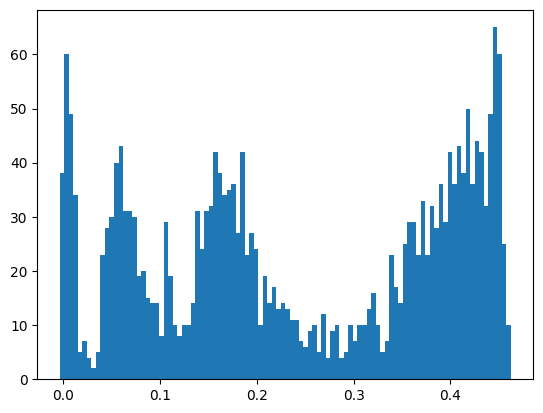

In [28]:
plt.hist(ths[:, 0, 0], bins=100)
plt.show()

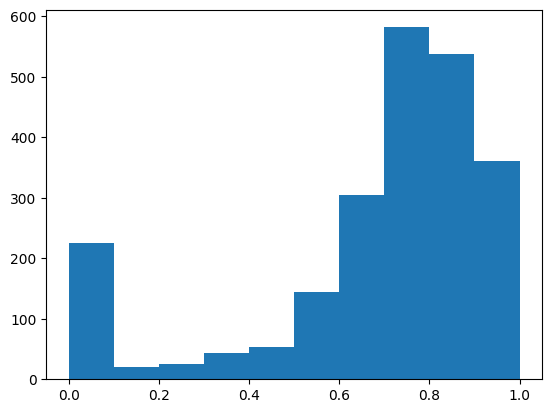

In [29]:
plt.hist(precision_test)
plt.show()

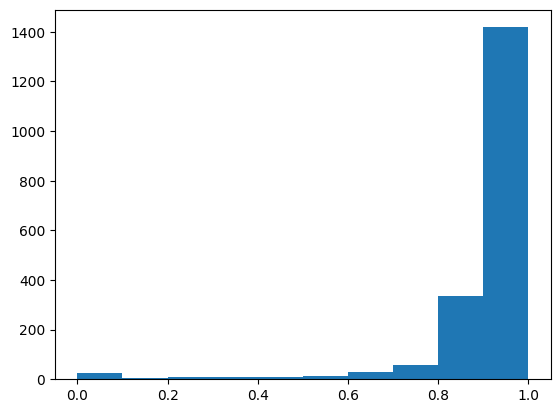

In [30]:
plt.hist(recall_test)
plt.show()

In [31]:
np.mean(precision_test)

0.6848839173804593

In [32]:
np.median(precision_test)

0.7565464965009185

In [74]:
if not os.path.exists(os.path.join(BASE_DIR, "05_multiaccurate_results", MODEL_NAME)):
    os.makedirs(os.path.join(BASE_DIR, "05_multiaccurate_results", MODEL_NAME))


np.save(os.path.join(BASE_DIR, "05_multiaccurate_results", MODEL_NAME, "theta.npy"), result.x)

In [75]:
result.x.shape

(1024,)

In [76]:
recalls = []
precisions = []
for th in tqdm(np.linspace(0, 1, 100)):
    pred_th = test_pred_probas >= th
    recall = (pred_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
    precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall))
    precisions.append(np.nanmean(precision))
    


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1749122/4188066551.py:5: RuntimeWarning: invalid value encountered in divide
  recall = (pred_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
/tmp/ipykernel_1749122/4188066551.py:6: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


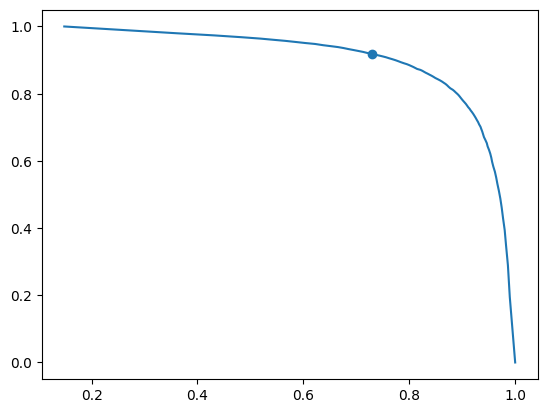

In [77]:
plt.plot(precisions, recalls)
plt.scatter(np.nanmean(precision_test), np.nanmean(recall_test))

In [50]:
np.nanmean(recall_test), np.nanmean(precision_test)

(0.9284999385131935, 0.6989669728822704)